# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from zipfile import ZipFile
from keras.utils.np_utils import to_categorical

print(tf.__version__)

2.4.1


# Загружаем разметку

In [ ]:
TRAIN_PREFIX = '/content/drive/MyDrive/БД/fish/train'

In [8]:
TRAIN_PREFIX_full = '/content/drive/MyDrive/БД/fish/train_full.zip'

with ZipFile(TRAIN_PREFIX_full, 'r') as z:
  z.extractall(".")

In [9]:
import os
import json
from glob import glob

def load_annotations():
    boxes = dict()
    for path in glob('/content/drive/MyDrive/БД/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                
                if label == 'nof':
                  annotation['filename'] = os.path.join('/content/train', 'NoF', basename)
                  # annotation['filename'] = os.path.join(TRAIN_PREFIX, 'NoF', basename)
                else:
                  annotation['filename'] = os.path.join('/content/train', label.upper(), basename)
                  # annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
                                
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
            
            if 'cls' in rect:
              cls = np.argmax(rect['cls'])
              cv2.putText(img,
                          INDEX_TO_CLS[cls] + ' %.3f' % rect['cls'][cls],
                          (pt1[0], pt1[1] - 5),
                          cv2.FONT_HERSHEY_SIMPLEX,
                          2,
                          color,
                          2)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [10]:
boxes = load_annotations()  # загружаем разметку детекций

In [11]:
CLS_TO_INDEX = {k: i for i, k in enumerate(sorted(boxes.keys()))}
INDEX_TO_CLS = {i: k for k, i in CLS_TO_INDEX.items()}

In [12]:
CLS_TO_INDEX

{'alb': 0,
 'bet': 1,
 'dol': 2,
 'lag': 3,
 'nof': 4,
 'other': 5,
 'shark': 6,
 'yft': 7}

In [13]:
INDEX_TO_CLS

{0: 'alb',
 1: 'bet',
 2: 'dol',
 3: 'lag',
 4: 'nof',
 5: 'other',
 6: 'shark',
 7: 'yft'}

In [14]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

class  count
0    yft    734
1    lag     67
2    bet    200
3    alb   1719
4  shark    176
5    dol    117
6  other    299
7    nof    465

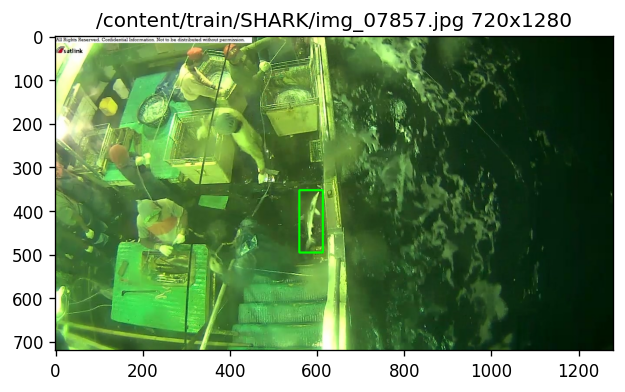

In [15]:
from matplotlib import pyplot as plt

annotation = boxes['shark'][1]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

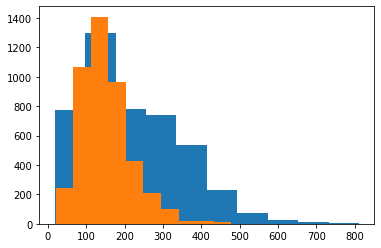

In [16]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [17]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58892288/58889256 [==============================] - 2s 0us/step
(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [18]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]
ANCHOR_CENTERS.shape

(2, 23, 37)

In [19]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, cls, num_classes, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], 
                              FEATURE_SHAPE[1], 
                              5 + num_classes), dtype=np.float32)
    
    # One-hot encoded class label
    cls_one_hot = tf.keras.utils.to_categorical(cls, num_classes).tolist() 

    x_scale = 1. * IMG_WIDTH / img_shape[1]    
    y_scale = 1. * IMG_HEIGHT / img_shape[0]   
    for rect in annotation['annotations']:     
        scores = []                            
        for row in range(FEATURE_SHAPE[0]):     
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)  
        if scores[0][0] < iou_thr:              
            scores = [scores[0]] # default anchor              
        else:                                 
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh] + cls_one_hot
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):                   
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col, :5]    
            conf = _sigmoid(logit)                        
            if conf > conf_thr:                          
                anchor_x = ANCHOR_CENTERS[1, row, col]   
                anchor_y = ANCHOR_CENTERS[0, row, col]

                # Распределение вероятности по классам
                cls_logit = prediction[row, col, 5:]
                cls_softmax = np.exp(cls_logit) / np.sum(np.exp(cls_logit))

                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH, 
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'cls': cls_softmax})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],        
              r['x'],         
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

In [20]:
def valid_enc_dec(annotation, cls):
  encoded = encode_anchors(annotation,
                          img_shape=(IMG_HEIGHT, IMG_WIDTH),
                          cls=CLS_TO_INDEX[cls],
                          num_classes=len(CLS_TO_INDEX),
                          iou_thr=0.5)

  decoded = decode_prediction(encoded, conf_thr=0.7)
  decoded = sorted(decoded, key = lambda e: -e['conf'])

  plt.figure(figsize=(6, 6), dpi=120)
  plt.imshow(draw_boxes(annotation, decoded))
  plt.title('{} {}x{}'.format(
      annotation['filename'], img.shape[0], img.shape[1]))

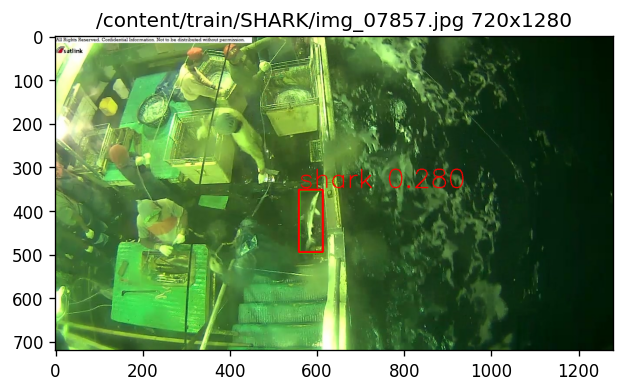

In [21]:
valid_enc_dec(boxes['shark'][1], 'shark')

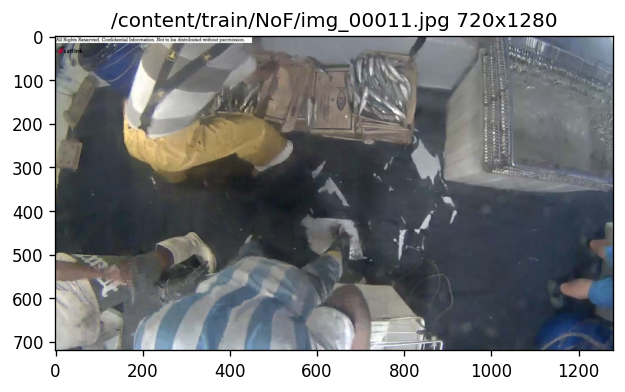

In [22]:
valid_enc_dec(boxes['nof'][1], 'nof')

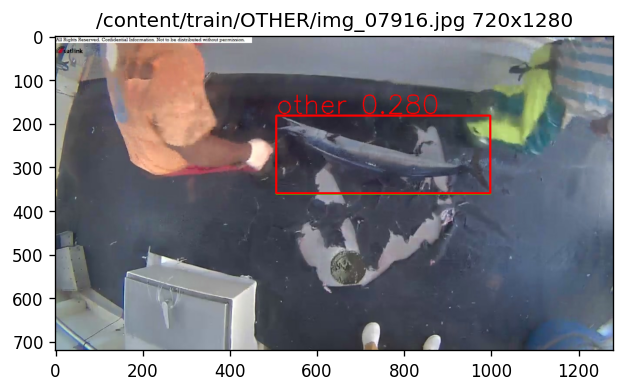

In [23]:
valid_enc_dec(boxes['other'][2], 'other')

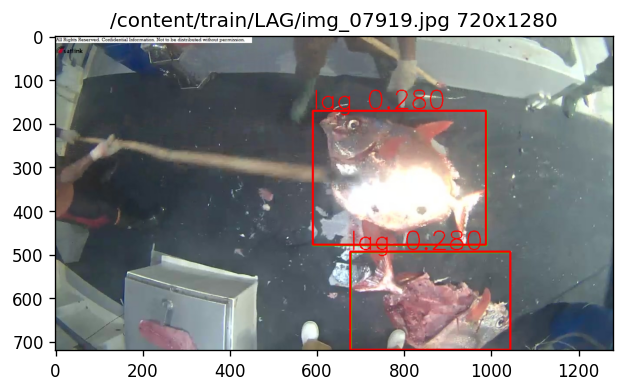

In [24]:
valid_enc_dec(boxes['lag'][0], 'lag')

## Функция потерь

In [25]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:5] - y_pred[..., 1:5])            
    square_loss = 0.5 * K.square(y_true[..., 1:5] - y_pred[..., 1:5]) 
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_true, y_pred):  
    class_loss = K.categorical_crossentropy(y_true[..., 5:], 
                                            y_pred[..., 5:],
                                            from_logits=True)
    return class_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5 + len(CLS_TO_INDEX)))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5 + len(CLS_TO_INDEX)))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # class loss
    class_loss = classification_loss(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    pos_class_loss = K.sum(class_loss * y_true[..., 0], axis=-1) 
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    # (Негативных примеров должно быть не более, чем в 3 раза больше, чем позитивных)
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    class_loss = pos_class_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + 0.25 * class_loss

## Загрузка данных

In [26]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum([[(k, box) for box in v] for k, v in boxes.items()], [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y,= [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                cls, box = boxes[j]
                img_shape, img = load_img(box['filename'])
                y.append(encode_anchors(box, img_shape,
                                        CLS_TO_INDEX[cls], len(CLS_TO_INDEX)))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [27]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5 + len(CLS_TO_INDEX),
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0     

## Обучение

In [28]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss, classification_loss])

In [29]:
batch_size = 18

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/БД/fish/fishdetector_weights_full.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=100)

In [30]:
model.load_weights('/content/drive/MyDrive/БД/fish/fishdetector_weights_full.hdf5')

In [ ]:
%%time

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
 93/209 [============>.................] - ETA: 11:24 - loss: 0.2137 - confidence_loss: 0.0186 - classification_loss: 1.1544e-04
Epoch 00001: loss improved from inf to 0.21373, saving model to /content/drive/MyDrive/БД/fish/fishdetector_weights_full.hdf5
193/209 [==========================>...] - ETA: 1:38 - loss: 0.2193 - confidence_loss: 0.0171 - classification_loss: 1.1026e-04
Epoch 00001: loss did not improve from 0.21373
209/209 [==============================] - 1231s 6s/step - loss: 0.2183 - confidence_loss: 0.0169 - classification_loss: 1.0950e-04
Epoch 2/10
 83/209 [==========>...................] - ETA: 12:21 - loss: 0.1814 - confidence_loss: 0.0131 - classification_loss: 9.0286e-05
Epoch 00002: loss improved from 0.21373 to 0.18144, saving model to /content/drive/MyDrive/БД/fish/fishdetector_weights_full.hdf5
183/209 [=========================>....] - ETA: 2:37 - loss: 0.1971 - confidence_loss: 0.0129 - classification_loss: 1.4233e-04
Epoch 00002: loss did not imp

## Результат работы детектора

In [ ]:
# model.load_weights('/content/drive/MyDrive/БД/fish/fishdetector_weights.hdf5')

In [82]:
s_nof = ["0.0", "0.0", "0.0", "0.0", "1.0", "0.0", "0.0", "0.0"] # если ничего не найдено - NoF

def visual(annotations, model, conf_thr=0.2, max_output_size=5):
  print('ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT\n')
    
  plt.figure(figsize=(6, 4 * len(annotations)), dpi=120)

  for i, annotation in enumerate(annotations, 1):
    _, sample_img = load_img(annotation['filename'])
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.25)
    decoded = non_max_suppression(decoded,
                                  max_output_size=5,
                                  iou_threshold=0.1)
    
    if len(decoded) == 0:
        print(f"{','.join(s_nof)}\n")
    else:
        print(f"{str(list(np.round(decoded[0]['cls'], 3)))[1:-1]}\n")

    img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))

    plt.subplot(len(annotation), 1, i)
    plt.imshow(img)
    plt.title('Предсказание модели: {}'.format('/'.join(annotation['filename'].split('/')[-3:])))
    print(' ')
  plt.show()

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0

 
0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.999, 0.0

 


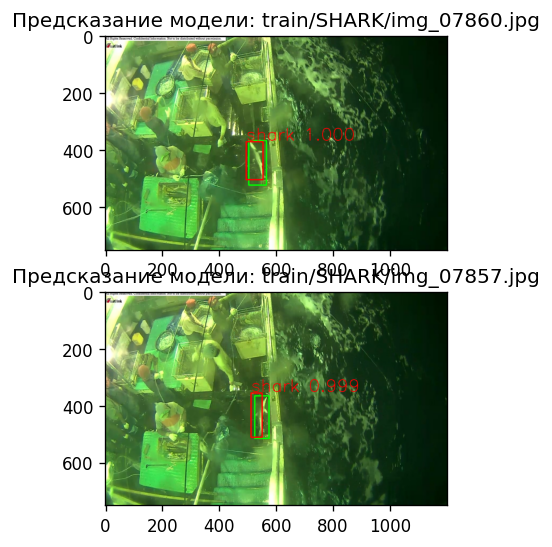

In [83]:
visual(boxes['shark'][:2], model)

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.998, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

 
1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

 


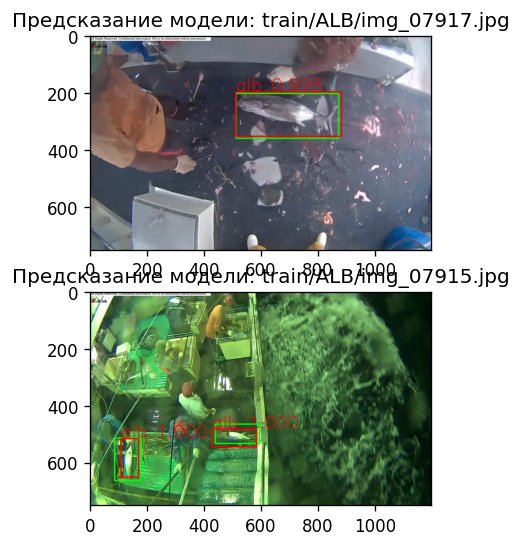

In [84]:
visual(boxes['alb'][:2], model)

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

 
0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

 


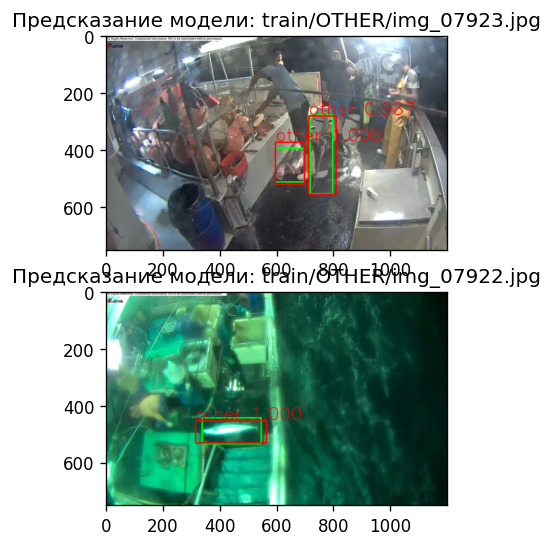

In [85]:
visual(boxes['other'][:2], model)

ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT

0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

 
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

 


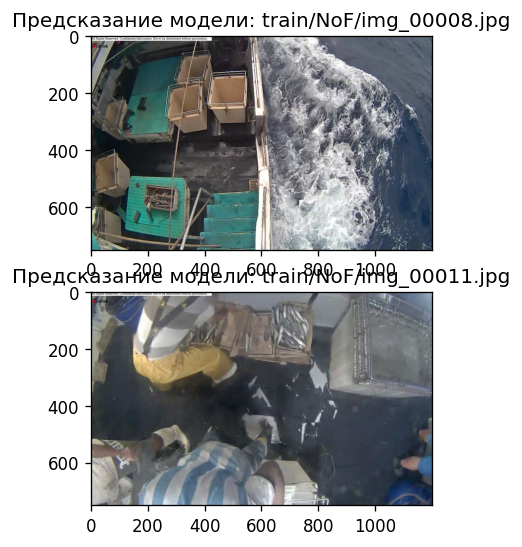

In [86]:
visual(boxes['nof'][:2], model)

## Визуализируем предсказание на пробном тесте

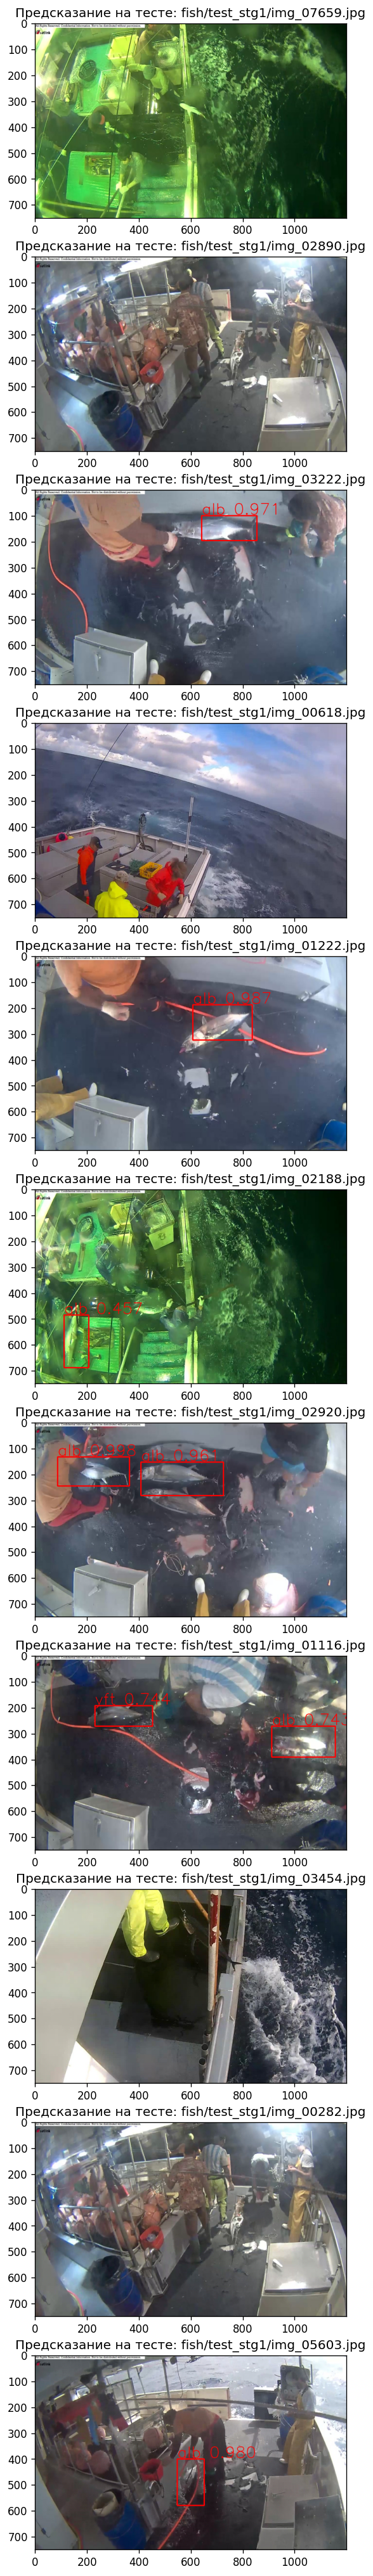

In [100]:
test_images = glob('/content/drive/MyDrive/БД/fish/test_stg1/*.jpg')[5:]



plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.02)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.subplot(len(test_images), 1, i + 1)
    plt.imshow(img)
    plt.title('Предсказание на тесте: {}'.format('/'.join(filename.split('/')[-3:])))
plt.show()



## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0


In [50]:
TEST_PREFIX_full_1 = '/content/drive/MyDrive/БД/fish/test_stg1_full.zip'
TEST_PREFIX_full_2 = '/content/drive/MyDrive/БД/fish/test_stg2_full.zip'

with ZipFile(TEST_PREFIX_full_1, 'r') as z:
  z.extractall(".")
with ZipFile(TEST_PREFIX_full_2, 'r') as z:
  z.extractall(".")

In [115]:
def load_test_images(TEST_PREFIX):
    images = []
    for path in glob(os.path.join(TEST_PREFIX, '*.jpg')):
        images.append(path)
    return images

test_images1 = sorted(load_test_images('/content/test_stg1'))
test_images2 = sorted(load_test_images('/content/test_stg2'))
# test_images =  sorted(test_images1 + test_images2)


In [116]:
print(len(test_images1))
print(len(test_images2))

1000
12153


In [121]:
with open('/content/drive/MyDrive/БД/fish/submition.csv', 'w') as f:
    f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for filename in test_images1:
      _, sample_img = load_img(filename)
      file_name = filename.split('/')[-1:]
      pred = model.predict(np.array([sample_img,]))

      decoded = decode_prediction(pred[0], conf_thr=0.1)
      decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
      if len(decoded) == 0:
        f.write(f"{''.join(file_name)}, {','.join(s_nof)}\n")
      else:
        f.write(f"{''.join(file_name)}, {str(list(decoded[0]['cls']))[1:-1]}\n")

    for filename in test_images2:
      _, sample_img = load_img(filename)
      file_name = '/'.join(filename.split('/')[-2:])
      pred = model.predict(np.array([sample_img,]))

      decoded = decode_prediction(pred[0], conf_thr=0.1)
      decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
      if len(decoded) == 0:
        f.write(f"{''.join(file_name)}, {','.join(s_nof)}\n")
      else:
        f.write(f"{''.join(file_name)}, {str(list(decoded[0]['cls']))[1:-1]}\n")


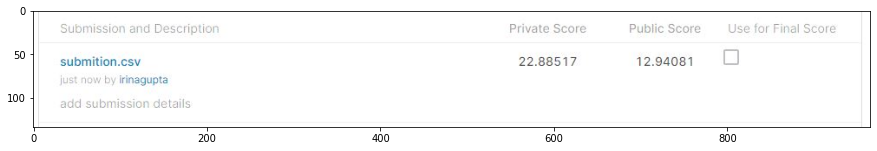

In [124]:
img_cv = cv2.imread('/content/drive/MyDrive/БД/fish/Submission.JPG')
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img_rgb)